In [ ]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader, random_split, Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, roc_curve, auc


from dataloader import CustomImageDataset
import random

In [40]:
# Parameters

attention = 1

In [6]:
# Define all the transforms

# Transform for loading dataset
transform_loading = transforms.Compose([
    transforms.Resize((64, 64)),  # resize to 64x64
    # transforms.Grayscale(),
    transforms.ToTensor()
])

In [31]:
# Create the dataset and dataloader

class_to_idx = {'sma': 1, 'non-sma': 0} # Dictionaty to assign 1 to 'sma' and 0 to 'non-sma' samples

# Get current directory
current_directory = os.getcwd()

# Relative directory of images
other_string = "Red_Cell_Morphology 2 rbc balanced"

# Combine directpries
new_path = os.path.join(current_directory, other_string)

# Create dataset
dataset = CustomImageDataset(root_dir=new_path, class_to_idx=class_to_idx, transform=transform_loading)

# Define the train, validation, and test ratios (e.g., 70%, 15%, 15%)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the number of samples for each split
num_samples = len(dataset)
train_samples = int(train_ratio * num_samples)
val_samples = int(val_ratio * num_samples)
test_samples = num_samples - train_samples - val_samples

# Use random_split to split the dataset
train_set, val_set, test_set = random_split(dataset, [train_samples, val_samples, test_samples])

# Create data loaders for each split
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)  # No need to shuffle validation set
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)  # No need to shuffle test set


In [32]:
# Get counts
counts = dataset.get_class_counts()
print(counts)

{'sma': 33, 'non-sma': 33}


Code that checks if the sample/bag has less than 20 RBC images and deleted the sample if they are less. This is not correct. TBD

In [ ]:
class SimpleCNN1(nn.Module):
    def __init__(self):
        super(SimpleCNN1, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(4 * 64 * 64, 500)  # Adjusted for input image size 224x224
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Perform individual feature extraction on each image
        features = []
        for img in x:
            img_features = self.pool(F.relu(self.conv1(img)))
            img_features = self.pool(F.relu(self.conv2(img_features)))            
            img_features = img_features.view(img_features.size(0), -1)  # Flatten layer
            img_features = F.relu(self.fc1(img_features))
            img_features = self.fc2(img_features)
            features.append(img_features)

        # Apply max pooling across all images
        pooled_features = torch.stack(features)
        # print(pooled_features.size())
        pooled_features, _ = torch.max(pooled_features, dim=0)
        # print(pooled_features.size())

        # Flatten the pooled features
        x = pooled_features.view(pooled_features.size(0), -1)

        x=F.relu(x)

        # Pass through the fully connected layers
        x = self.fc3(x)
        x = self.sigmoid(x)  # Apply sigmoid activation

        return x

In [43]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Use the first layers of ResNet-50 --> Look a bit more into this
        resnet = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:6]) # Check this(?)

        # Freeze the ResNet-50 weights
        for param in self.features.parameters():
            param.requires_grad = False
        
        self.fc2 = nn.Linear(32768, 2048)
        self.fc3 = nn.Linear(2048, 1)  # Adjusted for ResNet-50 output size
        self.sigmoid = nn.Sigmoid()

        # Attention weights and bias -- if needed
        self.attention_weights = nn.Linear(2048, 1)
        self.attention_bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        imgs_features = []

        # # Randomly choose k=50 images frm each bag of images in each training cycle
        # idxs=random.sample(range(len(x)),k=50)
        # x=[x[i] for i in idxs]

        # Independently pass each image (or a random subset) of a bag through the layers
        for img in x:
            # Pass through ResNet-50 layers
            img_features = self.features(img)
            # Flatten
            img_features = img_features.view(img_features.size(0), -1)
            # First linear from 32768 to 2048
            img_features=self.fc2(img_features)
            # Store in a list all the 2048 sized feature vectors for each sample
            imgs_features.append(img_features)

        # Apply max pooling across all images
        pooled_features = torch.stack(imgs_features)

        if attention == 1:
            # Attention pooling
            attention_weights = self.attention_weights(pooled_features)  # Calculate attention weights
            attention_weights = F.softmax(attention_weights, dim=0)  # Apply softmax to get attention probabilities
            pooled_features = pooled_features * attention_weights  # Apply attention weights
            pooled_features = torch.sum(pooled_features, dim=0)  # Sum the attention-weighted features

        elif attention == 0:
            pooled_features, _ = torch.max(pooled_features, dim=0)

        # Flatten the pooled features
        x = pooled_features.view(pooled_features.size(0), -1)



        # Pass through the fully connected layers
        x = self.fc3(x)
        x = self.sigmoid(x)  # Apply sigmoid activation

        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('This will run on', device)

This will run on cpu


In [29]:
# Step 4: Data resampling or class weights
# Option 1: Data Resampling - Oversampling the minority class
class_sample_count = torch.tensor(
    [(dataset.targets == t).sum() for t in torch.unique(dataset.targets, sorted=True)])

# weight = 1. / class_sample_count.float()
# samples_weight = weight[train_dataset_augmented_normalized.targets]
# sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

# Option 2: Class Weights
class_weights = 1. / class_sample_count.float()
class_weights = class_weights / class_weights.sum()
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

NameError: name 'train_dataset_augmented_normalized' is not defined

In [44]:
# Initialize the network and optimizer
net = SimpleCNN() 

net.to(device) # Move model to GPU ---> I have this twice

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.00001)

# Initialize lists to store accuracy values
train_accuracy_list = []
val_accuracy_list = []
test_accuracy = 0.0       
loss_tracker=[]

# Training loop
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader),desc=f'Epoch {epoch+1}/{1}', unit='batch',) as pbar:
        for i, data in enumerate(train_loader, 0):

            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            
            # Move each tensor in the list, all labels, and the model to the GPU
            inputs = [tensor.to(device) for tensor in inputs]
            labels = labels.to(device)
            net = net.to(device)
            
            # Make a prediciton by passing inputs sample through network
            target = net(inputs)
    
            # Calculate the loss
            loss = loss_fn(target[0],labels.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_tracker.append(loss)

            # Update accuracy
            predicted = target.data.round().int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # print statistics
            running_loss += loss.item()
            
             # Print loss in every minibatch
            # print(f'Epoch {epoch+1}/{1}, Minibatch {i+1}/{len(train_loader)}, Loss: {objective.item()}')
            pbar.update(1)

    # Calculate training accuracy
    train_accuracy = 100 * correct / total                                                                                      
    train_accuracy_list.append(train_accuracy)

    # Validation accuracy - store validation accuracy at the end of each epoch
    net.eval()  # Switch to evaluation mode                                                                                                                                                                     
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs = [tensor.to(device) for tensor in inputs]

            target = net(inputs)
            target = target.to(device)

            labels = labels.to(device)

            # Calculate validation accuracy
            predicted = target.data.round().int()
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_accuracy_list.append(val_accuracy)

        # Calculate F1 score for validation set
    val_predicted_probs = torch.sigmoid(target).cpu().numpy()
    val_predicted_labels = np.round(val_predicted_probs)
    val_f1 = f1_score(labels.cpu().numpy(), val_predicted_labels)

    # Calculate ROC curve for validation set
    fpr, tpr, _ = roc_curve(labels.cpu().numpy(), val_predicted_probs)
    val_roc_auc = auc(fpr, tpr)

 # Testing accuracy - calculate test accuracy at the end of training
net.eval()  # Switch to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = [tensor.to(device) for tensor in inputs]

        target = net(inputs)
        target = target.to(device)
        labels = labels.to(device)

        # Calculate test accuracy
        predicted = target.data.round().int()
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total

print(f'Training Accuracy: {train_accuracy_list[-1]:.2f}%')
print(f'Validation Accuracy: {val_accuracy_list[-1]:.2f}%')
print(f'Test Accuracy: {test_accuracy:.2f}%')

print('Finished Training')


plt.plot(val_accuracy_list)

Epoch 1/1:  22%|██▏       | 10/46 [01:48<06:30, 10.84s/batch]


KeyboardInterrupt: 

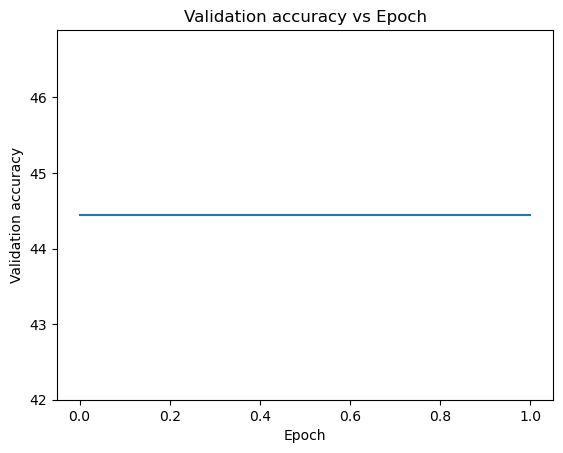

In [38]:
# Plot validation accuracy in each epoch

plt.plot(val_accuracy_list)
plt.title('Validation accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.show()

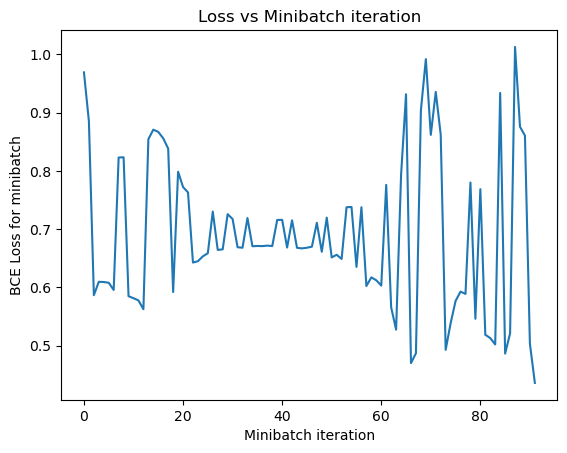

In [39]:
# Plot the loss against minibatch iteration
loss_all=[]

for i in range(len(loss_tracker)):
    loss_all.append(loss_tracker[i].item())

plt.plot(loss_all)
plt.title('Loss vs Minibatch iteration')
plt.xlabel('Minibatch iteration')
plt.ylabel('BCE Loss for minibatch')
plt.show()


In [32]:
test_total=0
test_correct=0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        target = net(inputs)
        print('target', target)
        print('labels: ', labels)

        # Calculate test accuracy
        print('target data:' , target.data)
        predicted = target.data.round().int()
        print('predicted', predicted)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(test_accuracy)

target tensor([[0.8240]])
labels:  tensor([1])
target data: tensor([[0.8240]])
predicted tensor([[1]], dtype=torch.int32)
target tensor([[0.8167]])
labels:  tensor([1])
target data: tensor([[0.8167]])
predicted tensor([[1]], dtype=torch.int32)
target tensor([[0.8113]])
labels:  tensor([1])
target data: tensor([[0.8113]])
predicted tensor([[1]], dtype=torch.int32)
target tensor([[0.8184]])
labels:  tensor([1])
target data: tensor([[0.8184]])
predicted tensor([[1]], dtype=torch.int32)
target tensor([[0.8050]])
labels:  tensor([1])
target data: tensor([[0.8050]])
predicted tensor([[1]], dtype=torch.int32)
target tensor([[0.8205]])
labels:  tensor([1])
target data: tensor([[0.8205]])
predicted tensor([[1]], dtype=torch.int32)
100.0
